# Data Collection

In [ ]:
!wget http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/vertical-misalignment.zip

--2022-02-05 21:13:28--  http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/vertical-misalignment.zip
Resolving www02.smt.ufrj.br (www02.smt.ufrj.br)... 146.164.99.22
Connecting to www02.smt.ufrj.br (www02.smt.ufrj.br)|146.164.99.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997431337 (1.9G) [application/zip]
Saving to: ‘vertical-misalignment.zip’

vertical-misalignme 100%[===================>]   1.86G  9.30MB/s    in 3m 41s  

2022-02-05 21:17:10 (8.62 MB/s) - ‘vertical-misalignment.zip’ saved [1997431337/1997431337]



In [ ]:
!mv /content/vertical-misalignment.zip /content/drive/MyDrive/FYP_FINAL/VMA

In [ ]:
# !unzip /content/drive/MyDrive/FinalYearProject/full.zip
!unzip /content/drive/MyDrive/FYP_FINAL/normal.zip
!unzip /content/drive/MyDrive/FYP_FINAL/VMA/vertical-misalignment.zip

# Imports & Functions

In [ ]:
# Installing libraries required
!pip install mat73
!pip install ewtpy
!pip install scaleogram

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import scipy
from scipy.io import loadmat
from scipy import signal
import mat73

import random
import pywt
import gc
import scaleogram as scg 

from skimage.transform import resize
from skimage import data, color
import ewtpy

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import itertools

from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.recurrent import LSTM
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Concatenate,Average



In [ ]:
def make_confusion_matrix(y_true,y_pred,classes=None, figsize=(10,10),text_size=15):
        """
        # Note: The following confusion matrix code is a remix of Scikit-Learn's 
        # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
        # and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
        """
    
        cm = confusion_matrix(y_true, tf.round(y_pred))
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0]

        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
        fig.colorbar(cax)

        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])


        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes),
                yticks=np.arange(n_classes),
                xticklabels=labels,
                yticklabels=labels)

    
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

    
        threshold = (cm.max() + cm.min()) / 2.


        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

In [ ]:
cur_path = "/content/"
normal_path = glob.glob(cur_path+'/normal/*.csv',recursive=True)
VMA_0_51mm_path = glob.glob(cur_path+'/vertical-misalignment/0.51mm/*.csv',recursive=True)
VMA_0_63mm_path = glob.glob(cur_path+'/vertical-misalignment/0.63mm/*.csv',recursive=True)
VMA_1_27mm_path = glob.glob(cur_path+'/vertical-misalignment/1.27mm/*.csv',recursive=True)
VMA_1_40mm_path = glob.glob(cur_path+'/vertical-misalignment/1.40mm/*.csv',recursive=True)
VMA_1_78mm_path = glob.glob(cur_path+'/vertical-misalignment/1.78mm/*.csv',recursive=True)
VMA_1_90mm_path = glob.glob(cur_path+'/vertical-misalignment/1.90mm/*.csv',recursive=True)

In [ ]:
columns=["Tachometer signal","ax_UBA","r_UBA","tan_UBA","ax_OBA","r_OBA","tan_OBA","mic"]

## Visualisation and Downsampling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


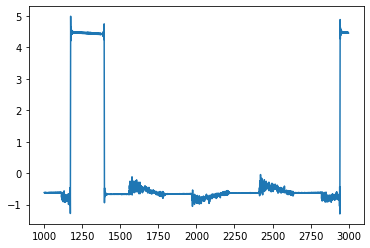

In [ ]:
pd.read_csv(normal_path[0],header=None)[1000:3000].iloc[:,0].plot()

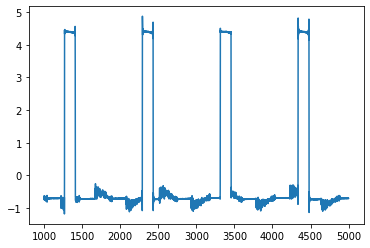

In [ ]:
pd.read_csv(VMA_0_51mm_path[0],header=None)[1000:5000].iloc[:,0].plot()

In [ ]:
num_samples=5000
def resampler(path):
    data_n = pd.DataFrame()
    for i in path:
        _data = pd.read_csv(i,header=None).to_numpy()
        resampled_df=pd.DataFrame()
        for j in range(8):
          resample=pd.DataFrame(signal.resample(_data[:,j],num_samples))
          resampled_df=pd.concat([resampled_df,resample],axis=1,ignore_index=True)

        data_n = pd.concat([data_n,resampled_df],ignore_index=True)
    return data_n

In [ ]:
data_n = resampler(normal_path)
data_vma0_51mm = resampler(VMA_0_51mm_path)
data_vma0_63mm = resampler(VMA_0_63mm_path)
data_vma1_27mm = resampler(VMA_1_27mm_path)
data_vma1_40mm = resampler(VMA_1_40mm_path)
data_vma1_78mm = resampler(VMA_1_78mm_path)
data_vma1_90mm = resampler(VMA_1_90mm_path)

In [ ]:
data_n.shape,data_vma0_51mm.shape 

((245000, 8), (255000, 8))

In [ ]:
data_n.columns=columns
data_vma0_51mm.columns=columns
data_vma0_63mm.columns=columns
data_vma1_27mm.columns=columns
data_vma1_40mm.columns=columns
data_vma1_78mm.columns=columns
data_vma1_90mm.columns=columns

In [ ]:
data_n

,Tachometer signal,ax_UBA,r_UBA,tan_UBA,ax_OBA,r_OBA,tan_OBA,mic
0,-0.566699,0.023993,-0.138019,-0.033846,-0.114549,-0.030432,0.234611,0.008049
1,-0.618317,-0.858789,-0.364228,-0.100950,1.007410,-0.006428,0.643547,0.107461
2,-0.714102,-0.703387,-0.249679,0.014161,0.671108,-0.005139,0.458381,0.067097
3,-0.611934,-0.645705,-0.386828,-0.069429,0.517288,-0.021504,0.537464,0.086510
4,-0.703227,-0.648516,0.307910,-0.083815,0.705244,0.007486,0.459270,0.047342
...,...,...,...,...,...,...,...,...
244995,-0.463714,-0.080637,-0.398921,0.010602,-0.104984,0.038468,-0.402640,0.021514
244996,-0.927827,0.445052,0.109670,-0.064875,0.283170,-0.027890,-0.486455,-0.024483
244997,-0.533009,-0.637016,0.056928,0.030377,1.057244,-0.019036,-0.621422,0.058483
244998,-0.870199,-0.739922,-0.410291,-0.017780,0.948341,-0.032512,-0.431243,0.040577


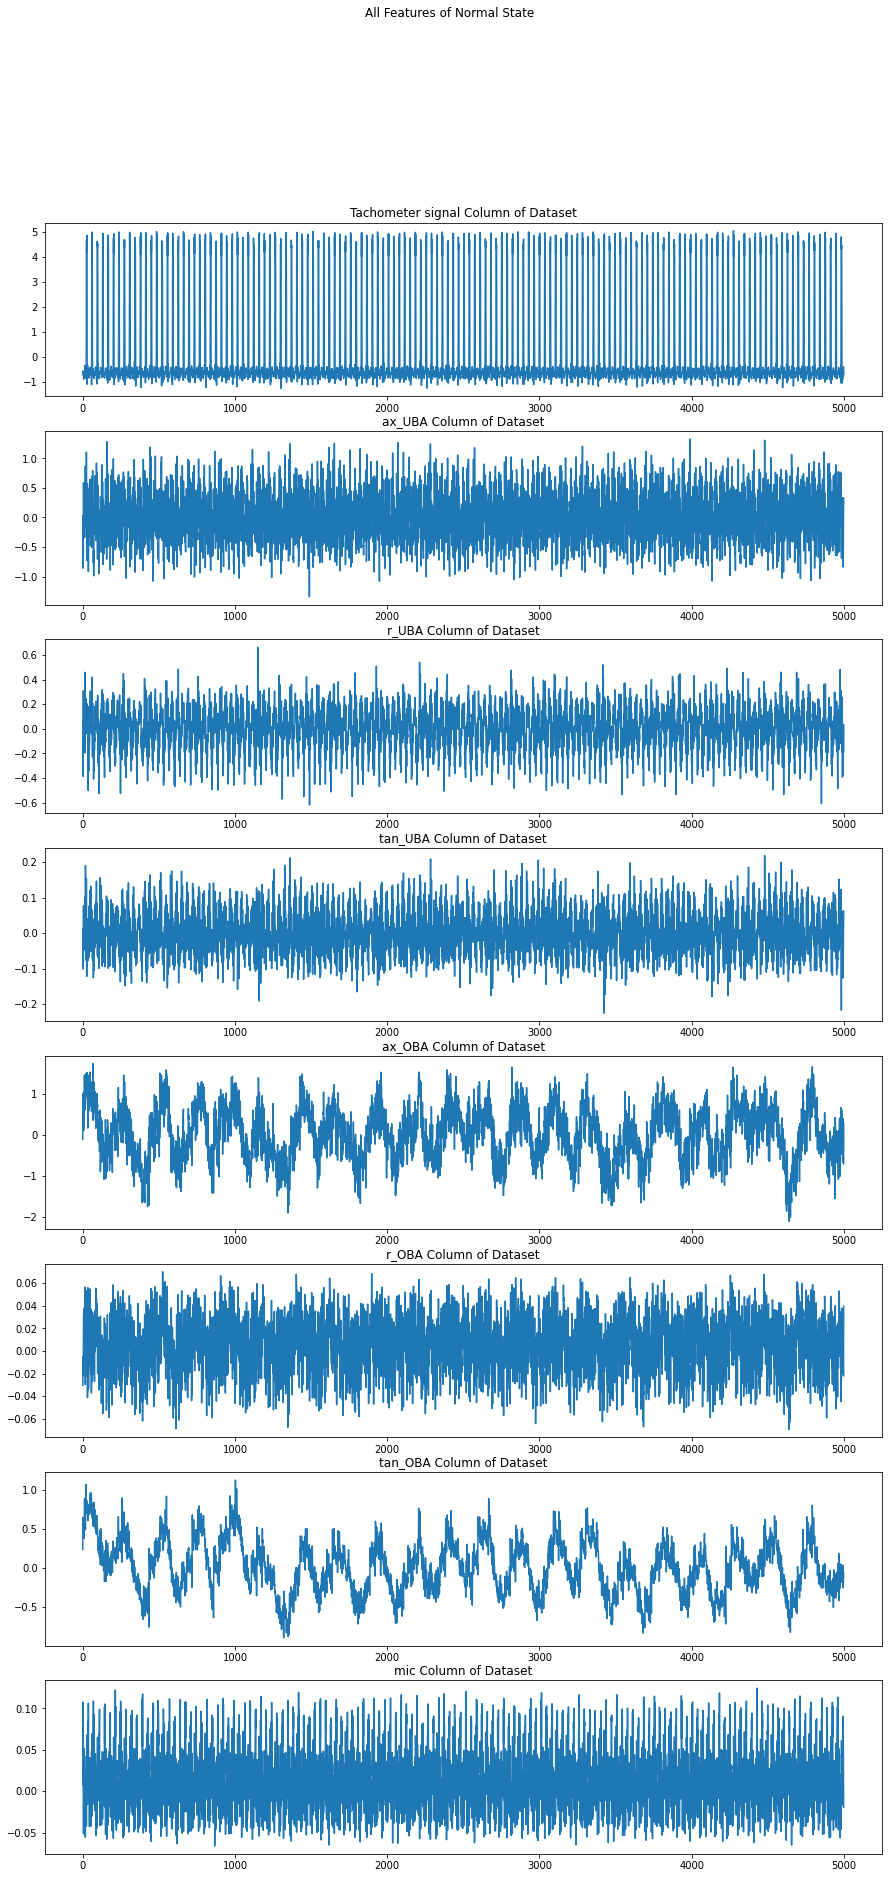

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Normal State')
for i in range(len(data_n.columns)):
    axs[i].plot(data_n[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

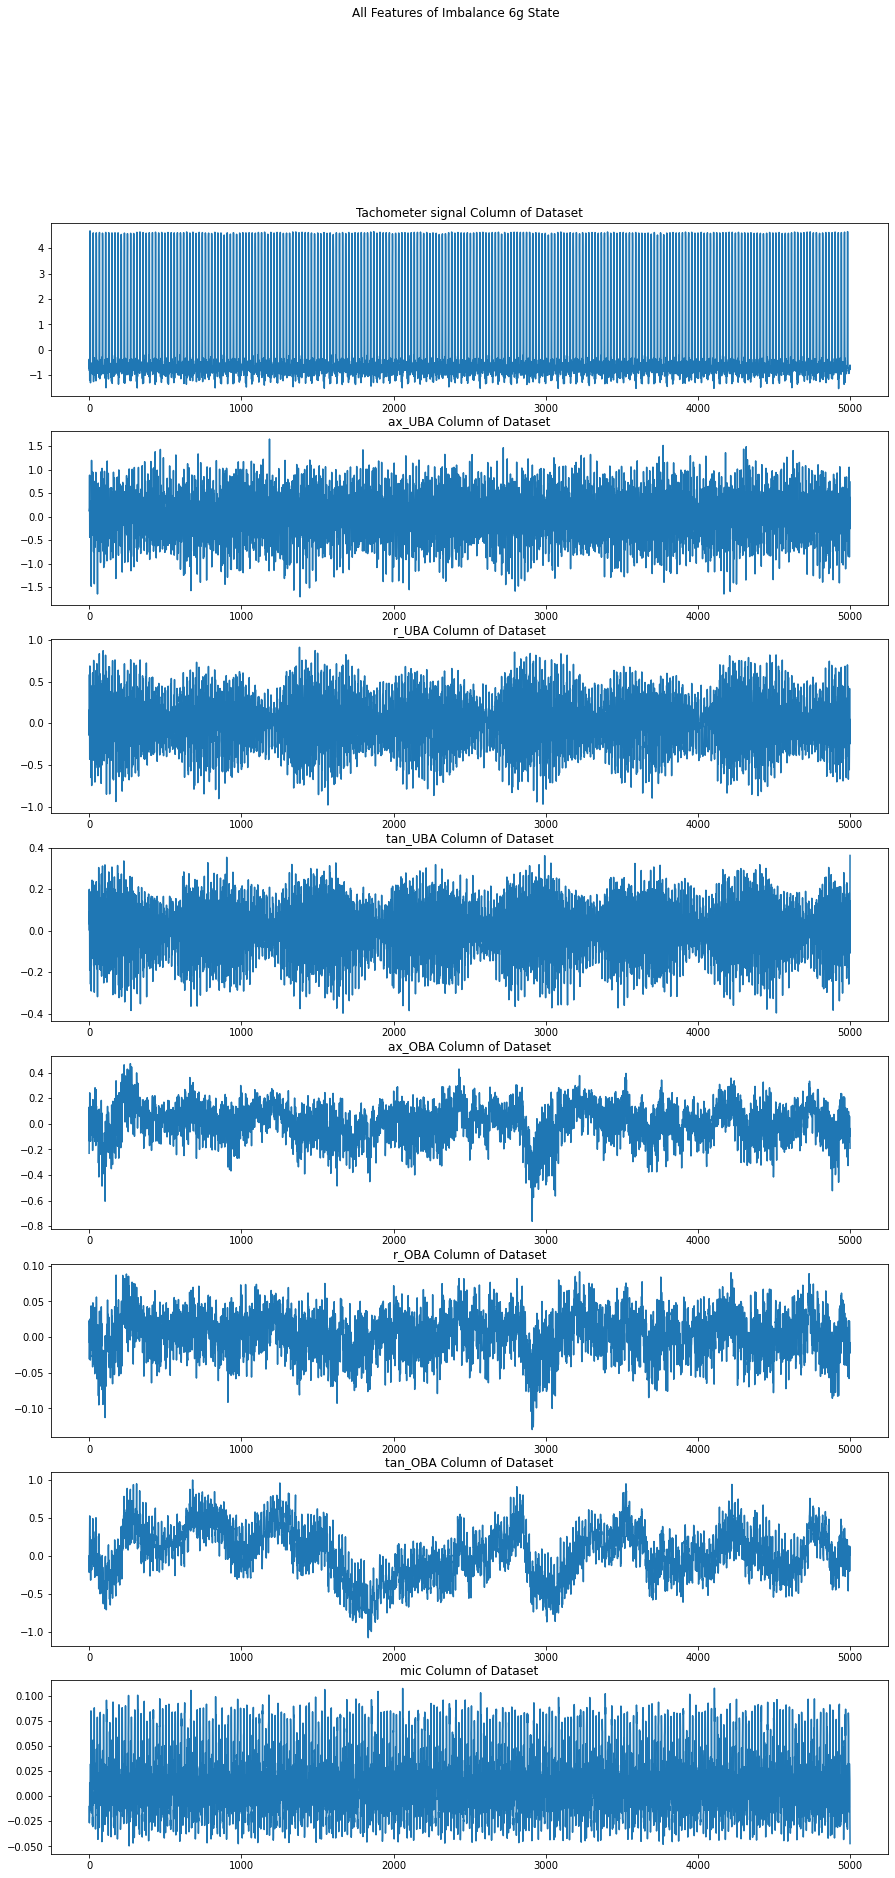

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Imbalance 6g State')
for i in range(len(data_vma0_51mm.columns)):
    axs[i].plot(data_vma0_51mm[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

# Data Preprocessing

In [ ]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245000 entries, 0 to 244999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Tachometer signal  245000 non-null  float64
 1   ax_UBA             245000 non-null  float64
 2   r_UBA              245000 non-null  float64
 3   tan_UBA            245000 non-null  float64
 4   ax_OBA             245000 non-null  float64
 5   r_OBA              245000 non-null  float64
 6   tan_OBA            245000 non-null  float64
 7   mic                245000 non-null  float64
dtypes: float64(8)
memory usage: 15.0 MB


**Misalignment (mm)	Measurements**
* 0.51	51
* 0.63	50
* 1.27	50
* 1.40	50
* 1.78	50
* 1.90	50

Total 301

 Normal	49

In [ ]:
x_0=data_n.to_numpy().reshape(-1,num_samples,8)
x_1=data_vma0_51mm.to_numpy().reshape(-1,num_samples,8)
x_2=data_vma0_63mm.to_numpy().reshape(-1,num_samples,8)
x_3=data_vma1_27mm.to_numpy().reshape(-1,num_samples,8)
x_4=data_vma1_40mm.to_numpy().reshape(-1,num_samples,8)
x_5=data_vma1_78mm.to_numpy().reshape(-1,num_samples,8)
x_6=data_vma1_90mm.to_numpy().reshape(-1,num_samples,8)

In [ ]:
X_data=np.vstack((x_0,x_1,x_2,x_3,x_4,x_5,x_6))
X_data.shape

(350, 5000, 8)

In [ ]:
y_0 = pd.DataFrame(np.zeros(int(len(x_0)),dtype=int))
y_1 = pd.DataFrame(np.ones(int(len(x_1)),dtype=int))
y_2 = pd.DataFrame(np.full((int(len(x_2)),1),2))
y_3 = pd.DataFrame(np.full((int(len(x_3)),1),3))
y_4 = pd.DataFrame(np.full((int(len(x_4)),1),4))
y_5 = pd.DataFrame(np.full((int(len(x_5)),1),5))
y_6 = pd.DataFrame(np.full((int(len(x_6)),1),6))
y_train_data = pd.concat([y_0,y_1,y_2,y_3,y_4,y_5,y_6], ignore_index=True).to_numpy()

In [ ]:
y_train_data.shape

(350, 1)

In [ ]:
y_train_data=y_train_data.reshape(-1)

In [ ]:
y_train_data.shape

(350,)

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_train_data, test_size=1 - train_ratio,stratify=y_train_data)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test) 


In [ ]:
X_train.shape,X_test.shape,X_val.shape

((244, 5000, 8), (53, 5000, 8), (53, 5000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((244,), (53,), (53,))

In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_train_rnn=np.array(np.ones((1,8)))
y_train_rnn=[]


count=0

for i in X_train:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_train_rnn=np.vstack((X_train_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_train_rnn.append(y_train[count])

  count+=1
  if count%50==0:
    print("Processed {} Train features ".format(count))
    print(X_train_rnn.shape)


Processed 50 Train features 
(1000001, 8)
Processed 100 Train features 
(2000001, 8)
Processed 150 Train features 
(3000001, 8)
Processed 200 Train features 
(4000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_test_rnn=np.array(np.ones((1,8)))
y_test_rnn=[]


count=0

for i in X_test:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_test_rnn=np.vstack((X_test_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_test_rnn.append(y_test[count])

  count+=1
  if count%50==0:
    print("Processed {} Test features ".format(count))
    print(X_test_rnn.shape)


Processed 50 Test features 
(1000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_val_rnn=np.array(np.ones((1,8)))
y_val_rnn=[]


count=0

for i in X_val:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_val_rnn=np.vstack((X_val_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_val_rnn.append(y_val[count])

  count+=1
  if count%50==0:
    print("Processed {} Val features ".format(count))
    print(X_val_rnn.shape)


Processed 50 Val features 
(1000001, 8)


In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((4880001, 8), (1060001, 8), (1060001, 8))

In [ ]:
X_train_rnn=X_train_rnn[1:,:].reshape(-1,time_frame,8)
X_test_rnn=X_test_rnn[1:,:].reshape(-1,time_frame,8)
X_val_rnn=X_val_rnn[1:,:].reshape(-1,time_frame,8)


In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((4880, 1000, 8), (1060, 1000, 8), (1060, 1000, 8))

In [ ]:
np.array(y_train_rnn).shape,np.array(y_test_rnn).shape,np.array(y_val_rnn).shape

((4880,), (1060,), (1060,))

In [ ]:
X_train=X_train_rnn
X_test=X_test_rnn
X_val=X_val_rnn

y_train=np.array(y_train_rnn)
y_test=np.array(y_test_rnn)
y_val=np.array(y_val_rnn)

In [ ]:
np.save("/content/drive/MyDrive/FYP_FINAL/VMA/X_train",X_train)
np.save("/content/drive/MyDrive/FYP_FINAL/VMA/X_test",X_test)
np.save("/content/drive/MyDrive/FYP_FINAL/VMA/X_val",X_val)

np.save("/content/drive/MyDrive/FYP_FINAL/VMA/y_train",y_train)
np.save("/content/drive/MyDrive/FYP_FINAL/VMA/y_test",y_test)
np.save("/content/drive/MyDrive/FYP_FINAL/VMA/y_val",y_val)

  

# Modelling

## CNN


In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_val.npy")


In [ ]:
np.unique(y_train,return_counts= True)

(array([0, 1, 2, 3, 4, 5, 6]), array([680, 700, 700, 700, 700, 700, 700]))

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((4880, 1000, 8), (1060, 1000, 8), (1060, 1000, 8))

In [ ]:
def func(x):
  if x in [1,2]:
    return 1
  elif x in [3,4]:
    return 2
  elif x in [5,6]:
    return 3
  else:
    return x

In [ ]:
np.unique(pd.Series(y_train).apply(func).to_numpy(),return_counts =True)

(array([0, 1, 2, 3]), array([ 680, 1400, 1400, 1400]))

In [ ]:
# y_train = pd.Series(y_train).apply(func).to_numpy()
# y_test = pd.Series(y_test).apply(func).to_numpy()
# y_val = pd.Series(y_val).apply(func).to_numpy()

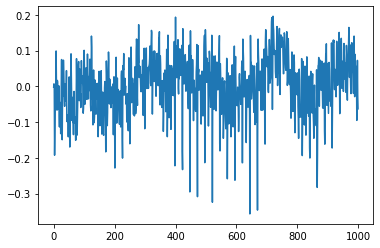

In [ ]:
i=500
j=4
signal=X_train[i,:,j]
plt.plot(signal)

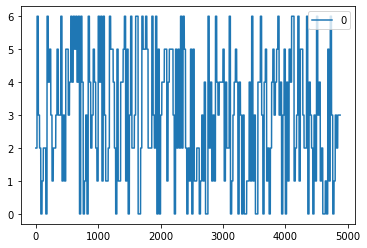

In [ ]:
pd.DataFrame(np.array(y_train)).plot()

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
 

In [ ]:
num_classes=7
n_timesteps=1000
n_features=8

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
batch_size = 16
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
alpha = 0.35
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha), input_shape=(n_timesteps,n_features)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.3))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 999, 128)          2176      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 499, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 498, 64)           16448     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 249, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_35 (Conv1D)          (None, 248, 32)           4128      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 124, 32)        

In [ ]:
checkpoint=ModelCheckpoint("/content/trained_model/hma_base_CNN.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=20,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=5,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=epochs, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks)

Epoch 1/100
304/305 [============================>.] - ETA: 0s - loss: 1.5975 - accuracy: 0.3207
Epoch 1: val_loss improved from inf to 1.28184, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


305/305 [==============================] - 8s 21ms/step - loss: 1.5962 - accuracy: 0.3215 - val_loss: 1.2818 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 2/100
305/305 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.5707
Epoch 2: val_loss improved from 1.28184 to 1.16135, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


305/305 [==============================] - 5s 16ms/step - loss: 0.9620 - accuracy: 0.5707 - val_loss: 1.1614 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 3/100
303/305 [============================>.] - ETA: 0s - loss: 0.6346 - accuracy: 0.7151
Epoch 3: val_loss improved from 1.16135 to 1.07526, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


305/305 [==============================] - 5s 16ms/step - loss: 0.6343 - accuracy: 0.7156 - val_loss: 1.0753 - val_accuracy: 0.7093 - lr: 0.0010
Epoch 4/100
305/305 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.8098
Epoch 4: val_loss did not improve from 1.07526
305/305 [==============================] - 3s 10ms/step - loss: 0.4576 - accuracy: 0.8098 - val_loss: 1.5163 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 5/100
302/305 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8733
Epoch 5: val_loss did not improve from 1.07526
305/305 [==============================] - 3s 10ms/step - loss: 0.3425 - accuracy: 0.8732 - val_loss: 1.2383 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 6/100
302/305 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8976
Epoch 6: val_loss did not improve from 1.07526
305/305 [==============================] - 3s 10ms/step - loss: 0.2824 - accuracy: 0.8982 - val_loss: 1.3562 - val_accuracy: 0.6799 -

INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


305/305 [==============================] - 5s 16ms/step - loss: 0.0506 - accuracy: 0.9859 - val_loss: 1.0654 - val_accuracy: 0.7822 - lr: 2.0000e-04
Epoch 10/100
300/305 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9919
Epoch 10: val_loss did not improve from 1.06540
305/305 [==============================] - 3s 11ms/step - loss: 0.0352 - accuracy: 0.9920 - val_loss: 1.1091 - val_accuracy: 0.7822 - lr: 2.0000e-04
Epoch 11/100
302/305 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9944
Epoch 11: val_loss did not improve from 1.06540
305/305 [==============================] - 4s 11ms/step - loss: 0.0294 - accuracy: 0.9943 - val_loss: 1.3177 - val_accuracy: 0.7869 - lr: 2.0000e-04
Epoch 12/100
302/305 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9938
Epoch 12: val_loss did not improve from 1.06540
305/305 [==============================] - 3s 11ms/step - loss: 0.0284 - accuracy: 0.9939 - val_loss: 1.3043 - val_

In [ ]:
class_names=["healthy","0.51mm","0.63mm","1.27mm","1.40mm","1.78mm","1.90mm"]
# class_names = ["healthy", "between 0.5mm and 1mm", "between 1mm and 1.5mm", "between 1.5mm and 2mm"]

In [ ]:
y_pred_probs=model.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

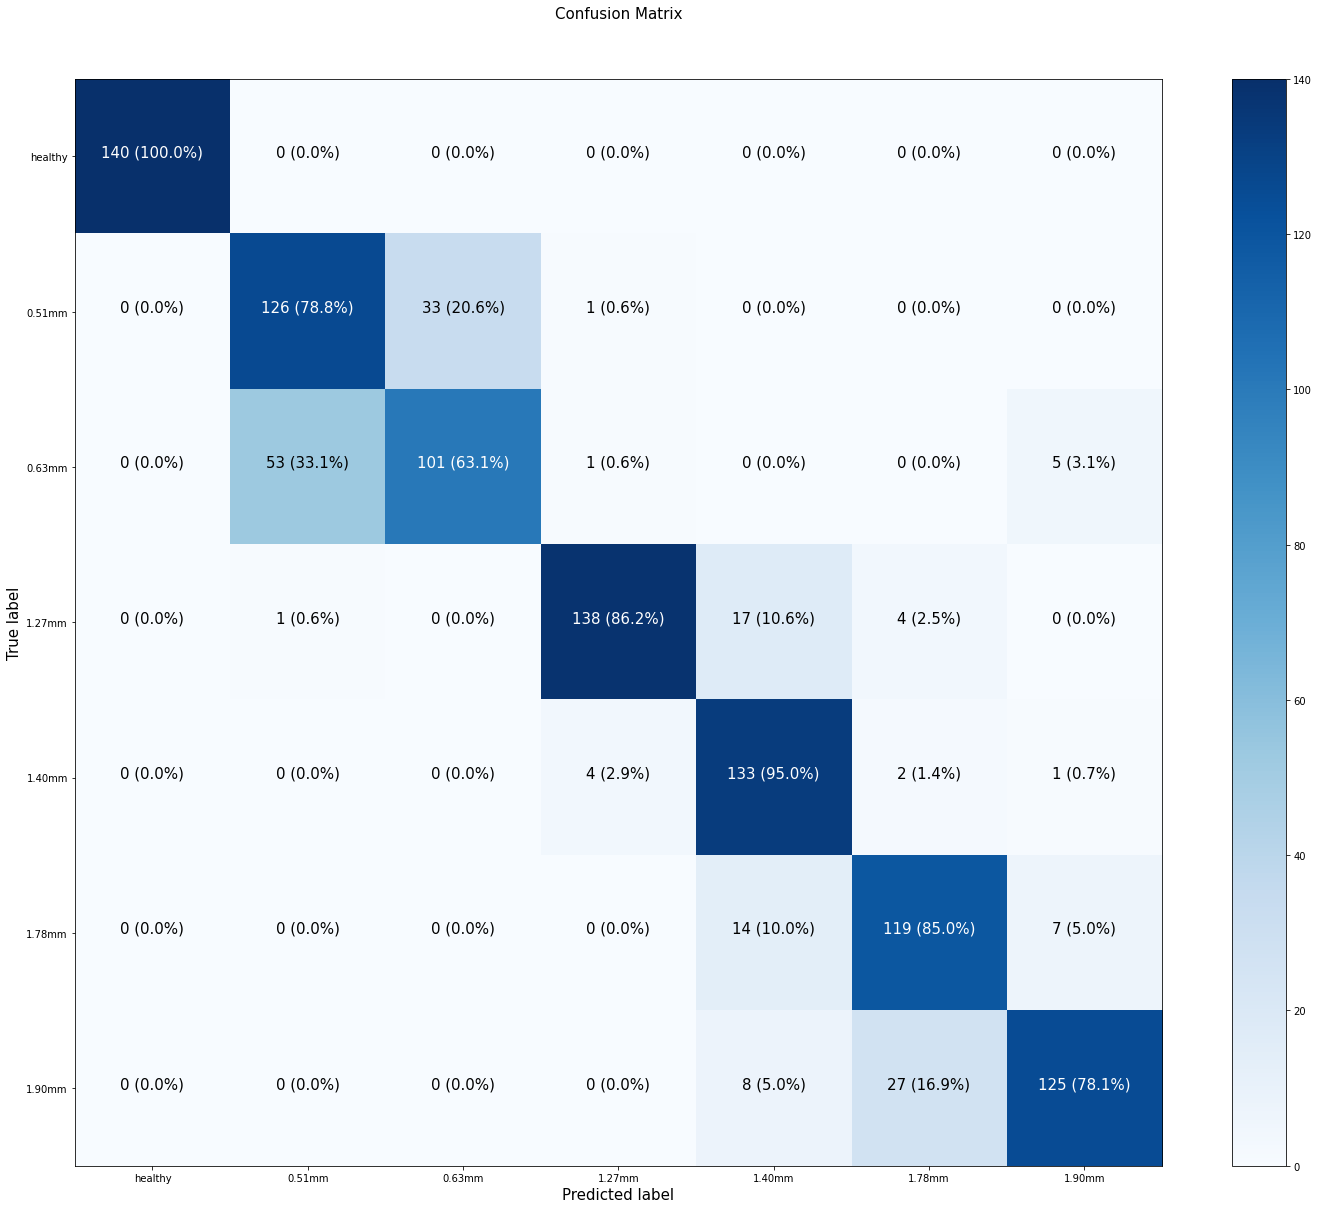

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(25,20))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       140
      0.51mm       0.70      0.79      0.74       160
      0.63mm       0.75      0.63      0.69       160
      1.27mm       0.96      0.86      0.91       160
      1.40mm       0.77      0.95      0.85       140
      1.78mm       0.78      0.85      0.82       140
      1.90mm       0.91      0.78      0.84       160

    accuracy                           0.83      1060
   macro avg       0.84      0.84      0.83      1060
weighted avg       0.84      0.83      0.83      1060



In [ ]:
model.evaluate(X_test,y_test)

34/34 [==============================] - 0s 8ms/step - loss: 1.8602 - accuracy: 0.8321


[1.8602219820022583, 0.8320754766464233]

In [ ]:
!zip -r /content/drive/MyDrive/FYP_FINAL/VMA/cnn_trained_model_apr.zip /content/trained_model

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/hma_base_CNN.hd5/ (stored 0%)
  adding: content/trained_model/hma_base_CNN.hd5/assets/ (stored 0%)
  adding: content/trained_model/hma_base_CNN.hd5/saved_model.pb (deflated 89%)
  adding: content/trained_model/hma_base_CNN.hd5/variables/ (stored 0%)
  adding: content/trained_model/hma_base_CNN.hd5/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/trained_model/hma_base_CNN.hd5/variables/variables.index (deflated 67%)
  adding: content/trained_model/hma_base_CNN.hd5/keras_metadata.pb (deflated 92%)


## EWT + CNN


### Procressing


In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_val.npy")


In [ ]:
X_train.shape,X_test.shape,X_val.shape

((4880, 1000, 8), (1060, 1000, 8), (1060, 1000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((4880,), (1060,), (1060,))

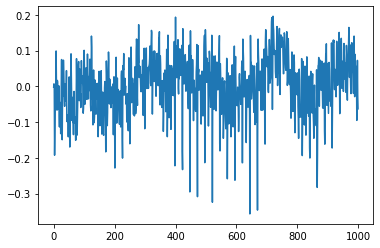

In [ ]:
i=500
j=4
sig = X_train[i,:,j]
plt.plot(sig)

In [ ]:
# Standardising and applying ewt transform
scaler = StandardScaler()
ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(sig.reshape(-1,1)).reshape(-1),N=201)

In [ ]:
ewt.shape

(1000, 201)

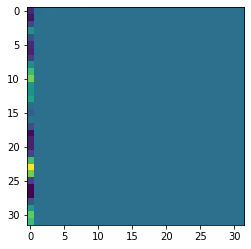

In [ ]:
plt.imshow(resize(ewt,(32,32)))

In [ ]:
train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
# Runtime is approx  5 hrs
train_data_ewt = np.ndarray(shape=(train_size, 64, 64, 8))

for i in range(0,train_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,train_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,train_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_train_data_ewt_epoch{}'.format(i),train_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_train[i,:,j].reshape(-1,1)).reshape(-1), N = 201)
        train_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Processsing 0/4880 features
Processsing 40/4880 features
Processsing 80/4880 features
Processsing 120/4880 features
Processsing 160/4880 features
Saving 199/4880 features
Processsing 200/4880 features
Processsing 240/4880 features
Processsing 280/4880 features
Processsing 320/4880 features
Processsing 360/4880 features
Saving 399/4880 features
Processsing 400/4880 features
Processsing 440/4880 features
Processsing 480/4880 features
Processsing 520/4880 features
Processsing 560/4880 features
Saving 599/4880 features
Processsing 600/4880 features
Processsing 640/4880 features
Processsing 680/4880 features
Processsing 720/4880 features
Processsing 760/4880 features
Saving 799/4880 features
Processsing 800/4880 features
Processsing 840/4880 features
Processsing 880/4880 features
Processsing 920/4880 features
Processsing 960/4880 features
Saving 999/4880 features
Processsing 1000/4880 features
Processsing 1040/4880 features
Processsing 1080/4880 features
Processsing 1120/4880 features
Proce

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_train_data_ewt_full',train_data_ewt)

In [ ]:
# Takes 90 mins
val_data_ewt = np.ndarray(shape=(val_size, 64, 64, 8))

for i in range(0,val_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,val_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,val_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_val_data_ewt_epoch{}'.format(i),val_data_ewt)
    for j in range(0,12):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_val[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        val_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_val_data_ewt_full',val_data_ewt)

In [ ]:
# Takes 90 mins
test_data_ewt = np.ndarray(shape=(test_size, 64, 64, 8))

for i in range(0,test_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,test_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,test_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_test_data_ewt_epoch{}'.format(i),test_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_test[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        test_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/VMA/vma_test_data_ewt_full',test_data_ewt)

### Setting correct shapes

In [ ]:
train_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/vma_train_data_ewt_full.npy")
test_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/vma_test_data_ewt_full.npy")
val_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/vma_val_data_ewt_full.npy")

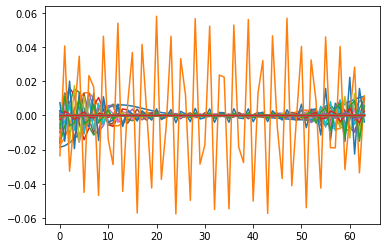

In [ ]:
plt.plot(train_data_ewt[-1][:,:,0]);

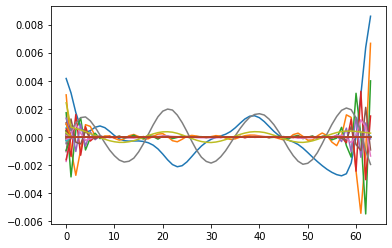

In [ ]:
plt.plot(test_data_ewt[-1][:,:,0]);

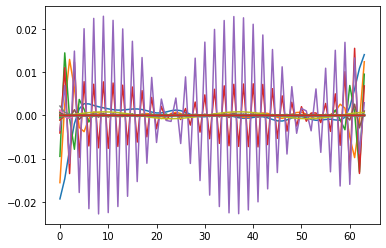

In [ ]:
plt.plot(val_data_ewt[-1][:,:,0]);

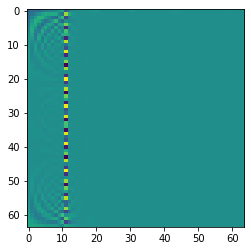

In [ ]:
plt.imshow(train_data_ewt[-1][:,:,0]);

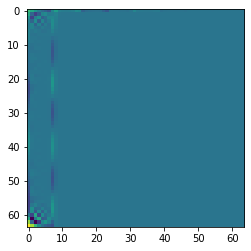

In [ ]:
plt.imshow(test_data_ewt[-1][:,:,0]);

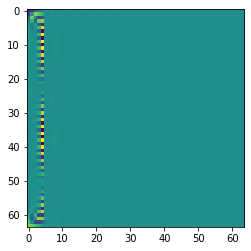

In [ ]:
plt.imshow(val_data_ewt[-1][:,:,0]);

In [ ]:
y_train=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/VMA/y_val.npy")

In [ ]:
# y_train = list(map(lambda x: int(x) - 1, y_train))
# y_test = list(map(lambda x: int(x) - 1, y_test))
# y_val = list(map(lambda x: int(x)-1,y_val))

# X_train = train_data_ewt
# y_train = list(y_train)
# X_test = test_data_ewt
# y_test = list(y_test)
# X_val = val_data_ewt
# y_val = list(y_val)

In [ ]:
X_train = train_data_ewt
X_test = test_data_ewt
X_val = val_data_ewt

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((4880, 64, 64, 8), (1060, 64, 64, 12), (1060, 64, 64, 8))

In [ ]:
X_test = X_test[:,:,:,:8]

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((4880, 64, 64, 8), (1060, 64, 64, 8), (1060, 64, 64, 8))

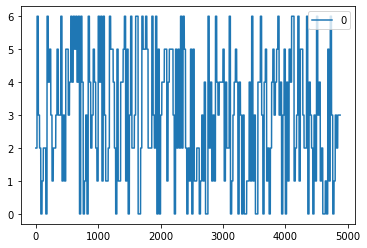

In [ ]:
pd.DataFrame(np.array(y_train)).plot()

In [ ]:
# X_train,y_train=shuffle(X_train, y_train)
# X_val,y_val=shuffle(X_val, y_val)
# X_test,y_test=shuffle(X_val, y_val)

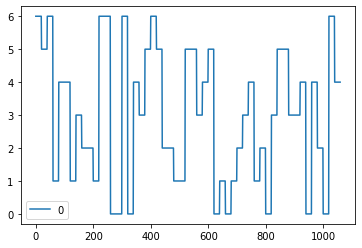

In [ ]:
pd.DataFrame(np.array(y_val)).plot();

In [ ]:
np.unique(y_test,return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]), array([140, 160, 160, 160, 140, 140, 160]))

In [ ]:
img_x = 64
img_y = 64
img_z = 8
input_shape = (img_x, img_y, img_z)
num_classes=7

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
 

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
X_val.shape

(1060, 64, 64, 8)

In [ ]:
y_val.shape

(1060, 7)

In [ ]:
X_train.shape

(4880, 64, 64, 8)

In [ ]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(4, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
 


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 61, 61, 8)         1032      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 59, 59, 8)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 59, 59, 8)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 57, 57, 8)         584       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 55, 55, 8)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 55, 55, 8)        

### Training

In [ ]:
batch_size = 6
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
checkpoint=ModelCheckpoint("/content/trained_model/EWT_CNN.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=epochs, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          )
 

Epoch 1/100
813/813 [==============================] - 9s 10ms/step - loss: 1.9215 - accuracy: 0.1779 - val_loss: 1.9471 - val_accuracy: 0.1515
Epoch 2/100
813/813 [==============================] - 8s 10ms/step - loss: 1.7261 - accuracy: 0.2866 - val_loss: 1.9544 - val_accuracy: 0.1695
Epoch 3/100
813/813 [==============================] - 8s 10ms/step - loss: 1.5466 - accuracy: 0.3562 - val_loss: 2.0002 - val_accuracy: 0.1742
Epoch 4/100
813/813 [==============================] - 8s 10ms/step - loss: 1.4520 - accuracy: 0.4007 - val_loss: 2.0522 - val_accuracy: 0.1553
Epoch 5/100
813/813 [==============================] - 8s 10ms/step - loss: 1.4020 - accuracy: 0.4288 - val_loss: 2.0953 - val_accuracy: 0.1562
Epoch 6/100
813/813 [==============================] - 9s 11ms/step - loss: 1.3494 - accuracy: 0.4397 - val_loss: 2.1809 - val_accuracy: 0.1534
Epoch 7/100
813/813 [==============================] - 8s 10ms/step - loss: 1.3115 - accuracy: 0.4594 - val_loss: 2.1848 - val_accuracy:

KeyboardInterrupt: ignored

### Evaluation

In [ ]:
classifier=tf.keras.models.load_model("/content/trained_model/EWT_CNN.hd5")

In [ ]:
y_pred_probs=classifier.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
class_names=["healthy","0.51mm","0.63mm","1.27mm","1.40mm","1.78mm","1.90mm"]

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

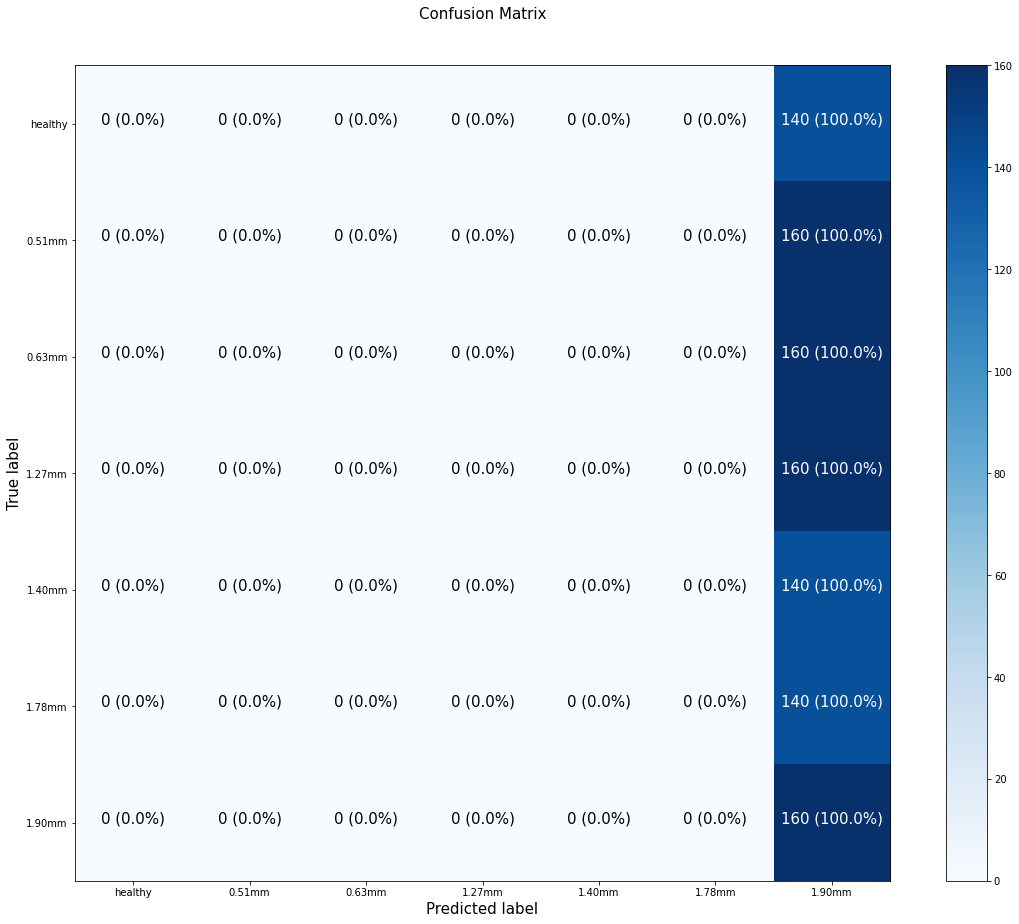

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(20,15))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00       140
      0.51mm       0.00      0.00      0.00       160
      0.63mm       0.00      0.00      0.00       160
      1.27mm       0.00      0.00      0.00       160
      1.40mm       0.00      0.00      0.00       140
      1.78mm       0.00      0.00      0.00       140
      1.90mm       0.15      1.00      0.26       160

    accuracy                           0.15      1060
   macro avg       0.02      0.14      0.04      1060
weighted avg       0.02      0.15      0.04      1060



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(X_test,y_test)

34/34 [==============================] - 1s 17ms/step - loss: 1.9450 - accuracy: 0.1509


[1.9450201988220215, 0.15094339847564697]

In [ ]:
model.evaluate(X_val,y_val)

In [ ]:
!zip -r /content/drive/MyDrive/FYP_FINAL/VMA/vma_ewt_trained_model.zip /content/trained_model